In [ ]:
!pip install xgboost

Top features selected by SelectKBest: Index(['age', 'credit_score_x', 'Approval', 'Follow-Up', 'Recency',
       'recency_score', 'R', 'time_spent_on_pages', 'click_through_rate',
       'credit_score_y'],
      dtype='object')
Top features selected by RFE: Index(['age', 'credit_score_x', 'customer_lifetime_value_x', 'Recency',
       'Monetary', 'website_visits', 'time_spent_on_pages', 'email_open_rate',
       'click_through_rate', 'credit_score_y'],
      dtype='object')
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.94      0.78       133
           1       0.27      0.04      0.08        67

    accuracy                           0.64       200
   macro avg       0.47      0.49      0.43       200
weighted avg       0.53      0.64      0.54       200

Random Forest ROC AUC Score: 0.4746380877567052
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.

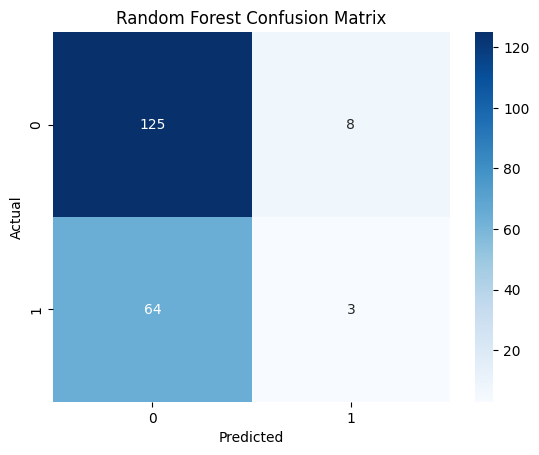

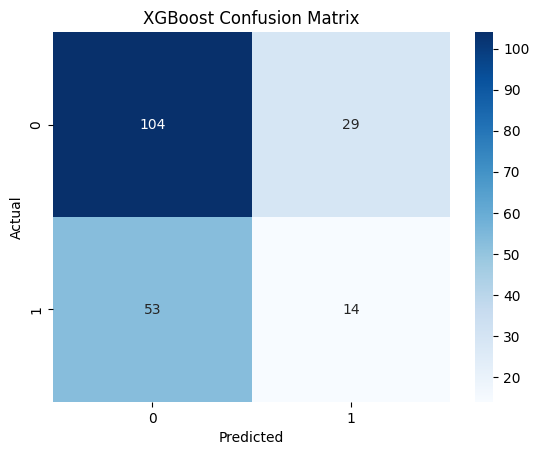

Simulated Data Prediction (Random Forest): [0 0 0 0 0 0 0 0 0 0]
Scaler, selected features, and models saved successfully.
Models saved successfully.


In [21]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE
import pickle

# Load Data
customer_transactions = pd.read_csv('D:/Jupyter_projects/RFM_loan/customer_transactions.csv')
loan_rfm = pd.read_csv('D:/Jupyter_projects/RFM_loan/loan_rfm.csv')
master_table = pd.read_csv('D:/Jupyter_projects/RFM_loan/master_table_updated.csv')
engagement_metrics = pd.read_csv('D:/Jupyter_projects/RFM_loan/engagement_metrics_updated.csv')
product_history = pd.read_csv('D:/Jupyter_projects/RFM_loan/product_history_with_transaction_types.csv')

# Encoding Transaction Patterns for Each Customer
transaction_features = customer_transactions.pivot_table(index='customer_id',  
                                                         columns='transaction_type', 
                                                         aggfunc='size', 
                                                         fill_value=0)

# Merging All Data
merged_data = master_table.merge(transaction_features, on='customer_id', how='left') \
                          .merge(loan_rfm, on='customer_id', how='left') \
                          .merge(engagement_metrics, on='customer_id', how='left') \
                          .merge(product_history[['customer_id', 'application_history']], on='customer_id', how='left')

# Label Encoding the Target Variable
merged_data['application_status'] = merged_data['application_history'].apply(lambda x: 1 if x == 'Approved' else 0)
merged_data.drop(columns=['application_history'], inplace=True)

# Convert columns that should be numeric but may have been read as strings
for col in merged_data.columns:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Remove irrelevant columns that cannot be used in machine learning models
irrelevant_columns = ['registration_date', 'income_level', 'location', 'risk_profile', 'RFM_Segment', 'customer_id']
merged_data.drop(columns=irrelevant_columns, errors='ignore', inplace=True)

# Fill missing values separately for numeric and categorical columns
numeric_cols = merged_data.select_dtypes(include=[np.number]).columns
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(merged_data[numeric_cols].mean())

categorical_cols = merged_data.select_dtypes(exclude=[np.number]).columns
if len(categorical_cols) > 0:
    merged_data[categorical_cols] = merged_data[categorical_cols].fillna(merged_data[categorical_cols].mode().iloc[0])

# Splitting Data
X = merged_data.drop(columns=['application_status'])
y = merged_data['application_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle any remaining NaN values in training and test sets after splitting
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Apply MinMaxScaler to ensure all values are in [0, 1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert transformed arrays back to DataFrame for compatibility with feature names
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Feature Selection Techniques
# 1. SelectKBest - Chi-Squared Test (requires non-negative values)
select_kbest = SelectKBest(score_func=chi2, k=10)
X_kbest = select_kbest.fit_transform(X_train, y_train)
selected_features_kbest = X_train.columns[select_kbest.get_support()]
print("Top features selected by SelectKBest:", selected_features_kbest)

# 2. Recursive Feature Elimination (RFE) - Random Forest Classifier
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfe.get_support()]
print("Top features selected by RFE:", selected_features_rfe)

# Modeling - Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train[selected_features_kbest], y_train)
rf_pred = rf_model.predict(X_test[selected_features_kbest])
print("Random Forest Classification Report:\n", classification_report(y_test, rf_pred))
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test[selected_features_kbest])[:, 1]))

# Modeling - XGBoost (without use_label_encoder parameter)
xgb_model = XGBClassifier(eval_metric='logloss')  # Removed 'use_label_encoder' parameter
xgb_model.fit(X_train[selected_features_kbest], y_train)
xgb_pred = xgb_model.predict(X_test[selected_features_kbest])
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_pred))
print("XGBoost ROC AUC Score:", roc_auc_score(y_test, xgb_model.predict_proba(X_test[selected_features_kbest])[:, 1]))

# Confusion Matrix for Models
models = {'Random Forest': rf_pred, 'XGBoost': xgb_pred}
for model_name, preds in models.items():
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Simulating New Data for Robustness Testing
def simulate_new_data(df, n=100):
    simulated_data = df.sample(n, replace=True)
    simulated_data = simulated_data.apply(lambda x: x + np.random.normal(0, 0.1) if x.name in numeric_cols else x)
    return simulated_data

new_data = simulate_new_data(X_test)
new_preds_rf = rf_model.predict(new_data[selected_features_kbest])
print("Simulated Data Prediction (Random Forest):", new_preds_rf[:10])

# Saving the Models
# with open('rf_model.pkl', 'wb') as file:
#     pickle.dump(rf_model, file)
# with open('xgb_model.pkl', 'wb') as file:
#     pickle.dump(xgb_model, file)

# Save the scaler
# with open('D:/Jupyter_projects/RFM_loan/scaler.pkl', 'wb') as scaler_file:
#     pickle.dump(scaler, scaler_file)

# Assuming `X_train` is the training DataFrame with feature names
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit scaler with feature names

# Save the scaler with feature names for consistent future scaling
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)


# Save the selected features from SelectKBest
with open('D:/Jupyter_projects/RFM_loan/selected_features_kbest.pkl', 'wb') as features_file:
    pickle.dump(selected_features_kbest, features_file)

# Save the Random Forest and XGBoost models as before
with open('D:/Jupyter_projects/RFM_loan/rf_model.pkl', 'wb') as rf_file:
    pickle.dump(rf_model, rf_file)
    
with open('D:/Jupyter_projects/RFM_loan/xgb_model.pkl', 'wb') as xgb_file:
    pickle.dump(xgb_model, xgb_file)

print("Scaler, selected features, and models saved successfully.")


print("Models saved successfully.")


In [20]:
import pickle
import pandas as pd
import numpy as np

# Load the models, scaler, and selected features list from saved files
with open('D:/Jupyter_projects/RFM_loan/rf_model.pkl', 'rb') as rf_file:
    rf_model = pickle.load(rf_file)

with open('D:/Jupyter_projects/RFM_loan/xgb_model.pkl', 'rb') as xgb_file:
    xgb_model = pickle.load(xgb_file)

with open('D:/Jupyter_projects/RFM_loan/scaler.pkl', 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

with open('D:/Jupyter_projects/RFM_loan/selected_features_kbest.pkl', 'rb') as features_file:
    selected_features_kbest = pickle.load(features_file)

# Define new transaction data with the selected features
# new_transaction_data_dict = {
#     'website_visits': [20],
#     'time_spent_on_pages': [15.2],
#     'email_open_rate': [0.45],
#     'click_through_rate': [0.25],
#     'credit_score': [680],
#     'customer_lifetime_value': [30000],
#     'Recency': [45],
#     'Frequency': [10],
#     'Monetary': [15000],
#     'recency_score': [2],
#     'frequency_score': [3],
#     'monetary_score': [4]
# }

# Define new transaction data with updated values for higher propensity
new_transaction_data_dict = {
    'website_visits': [50],              # Higher number of website visits indicating frequent engagement
    'time_spent_on_pages': [25.5],       # Increased time spent on pages suggesting more interest
    'email_open_rate': [0.75],           # High email open rate showing engagement with communications
    'click_through_rate': [0.5],         # High click-through rate on email or digital ads
    'credit_score': [750],               # Higher credit score, indicating a more favorable financial profile
    'customer_lifetime_value': [45000],  # Higher customer lifetime value predicting greater revenue potential
    'Recency': [10],                     # Recent interaction (lower value) indicating frequent engagement
    'Frequency': [20],                   # High transaction frequency indicating regular purchases
    'Monetary': [25000],                 # Higher total monetary value for transactions
    'recency_score': [4],                # Higher recency score (e.g., 1-5 scale, closer to recent engagement)
    'frequency_score': [4],              # High frequency score suggesting frequent purchases
    'monetary_score': [5]                # High monetary score indicating significant spending
}


# Convert the dictionary to a DataFrame
new_transaction_data = pd.DataFrame(new_transaction_data_dict)

# Add missing columns with zero values to match the original feature set used for scaling
original_features = X.columns  # Replace X with your original features DataFrame from training
for col in original_features:
    if col not in new_transaction_data.columns:
        new_transaction_data[col] = 0

# Reorder columns to match the scaler's training features
new_transaction_data = new_transaction_data[original_features]

# Apply the scaler to standardize the new data
new_transaction_data_scaled = scaler.transform(new_transaction_data)

# Convert scaled data to a DataFrame with selected features
new_transaction_data_df = pd.DataFrame(new_transaction_data_scaled, columns=new_transaction_data.columns)
new_transaction_data_selected = new_transaction_data_df[selected_features_kbest]

# Predict propensity score using both models
propensity_score_rf = rf_model.predict_proba(new_transaction_data_selected)[:, 1][0]
propensity_score_xgb = xgb_model.predict_proba(new_transaction_data_selected)[:, 1][0]

print(f"Propensity score (Random Forest): {propensity_score_rf:.2f}")
print(f"Propensity score (XGBoost): {propensity_score_xgb:.2f}")

# Cross-sell recommendation based on the propensity score
threshold = 0.7
if propensity_score_rf > threshold:
    print("Cross-Sell Recommendation (Random Forest): Recommend Product X")
if propensity_score_xgb > threshold:
    print("Cross-Sell Recommendation (XGBoost): Recommend Product X")
else:
    print("No strong cross-sell opportunity detected based on current propensity scores.")


Propensity score (Random Forest): 0.35
Propensity score (XGBoost): 0.04
No strong cross-sell opportunity detected based on current propensity scores.


D:\Jupyter_projects\credit_score\credit_scoring_env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [23]:
import pickle
import pandas as pd

# Load the models, scaler, and selected features list
with open('D:/Jupyter_projects/RFM_loan/rf_model.pkl', 'rb') as rf_file:
    rf_model = pickle.load(rf_file)

with open('D:/Jupyter_projects/RFM_loan/xgb_model.pkl', 'rb') as xgb_file:
    xgb_model = pickle.load(xgb_file)

with open('D:/Jupyter_projects/RFM_loan/scaler.pkl', 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

with open('D:/Jupyter_projects/RFM_loan/selected_features_kbest.pkl', 'rb') as features_file:
    selected_features_kbest = pickle.load(features_file)

# Load original feature names
with open('D:/Jupyter_projects/RFM_loan/original_features.pkl', 'rb') as feature_file:
    original_features = pickle.load(feature_file)

# Define new transaction data with high propensity values
new_transaction_data_dict = {
    'website_visits': [50],
    'time_spent_on_pages': [25.5],
    'email_open_rate': [0.75],
    'click_through_rate': [0.5],
    'credit_score': [750],
    'customer_lifetime_value': [45000],
    'Recency': [10],
    'Frequency': [20],
    'Monetary': [25000],
    'recency_score': [4],
    'frequency_score': [4],
    'monetary_score': [5]
}

# Convert to DataFrame and add missing columns with zero values
new_transaction_data = pd.DataFrame(new_transaction_data_dict)

for col in original_features:
    if col not in new_transaction_data.columns:
        new_transaction_data[col] = 0

# Reorder columns to match the original feature order and apply scaling
new_transaction_data = new_transaction_data[original_features]
new_transaction_data_scaled = scaler.transform(new_transaction_data)

# Convert scaled data to a DataFrame with selected features
new_transaction_data_df = pd.DataFrame(new_transaction_data_scaled, columns=new_transaction_data.columns)
new_transaction_data_selected = new_transaction_data_df[selected_features_kbest]

# Predict propensity score using both models
propensity_score_rf = rf_model.predict_proba(new_transaction_data_selected)[:, 1][0]
propensity_score_xgb = xgb_model.predict_proba(new_transaction_data_selected)[:, 1][0]

print(f"Propensity score (Random Forest): {propensity_score_rf:.2f}")
print(f"Propensity score (XGBoost): {propensity_score_xgb:.2f}")

# Cross-sell recommendation based on propensity score
threshold = 0.7
if propensity_score_rf > threshold:
    print("Cross-Sell Recommendation (Random Forest): Recommend Product X")
if propensity_score_xgb > threshold:
    print("Cross-Sell Recommendation (XGBoost): Recommend Product X")
else:
    print("No strong cross-sell opportunity detected based on current propensity scores.")


FileNotFoundError: [Errno 2] No such file or directory: 'D:/Jupyter_projects/RFM_loan/original_features.pkl'

D:\Jupyter_projects\credit_score\credit_scoring_env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


ValueError: X has 12 features, but MinMaxScaler is expecting 23 features as input.